# Question 4

In [1]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

Here for Question 4 I have created another Notebook and i have started with loading all the necessary libraries and
again I have used sklearn library for splitting the data.

In [2]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    O	a
    O	great
    O	lunch
    O	spot
    O	but
    B-Hours	open
    I-Hours	till
    I-Hours	2
    I-Hours	a
    I-Hours	m
    B-Restaurant_Name	passims
    I-Restaurant_Name	kitchen
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [3]:
raw_training_data = get_raw_data_from_bio_file("engtrain.bio.txt") 

In [4]:
train_data, development_data = train_test_split(raw_training_data, train_size=0.8, shuffle = False)

Here I have used train_test_split to split the data into training data which is 80% and remaining 20% is the development_set which is 20%.

In [5]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""
    

    preprocessed_example = [] # trivial- no preprocessing
    postagger = CRFTagger()
    postagger .set_model_file("crf_pos.tagger")
    Words=[]
    for i in example:
        Words.append(i[0])
        postagwords= postagger.tag(Words)
        for j in range (len(postagwords)):
            str = ''
            str = str + postagwords[j][0] + '@' + postagwords[j][1]
            word = tuple([str, example[j][1]])
            preprocessed_example.append(word)
    return preprocessed_example

Here in the preProcess fucniton we have added '@' tag between words and pos tags, We have to do this because the CRF tagger takes string only input so here i have concatenated the words and their respective postags with @.

In [6]:
development_data1 = [preProcess(example) for example in development_data]

In [7]:
train_data1 = [preProcess(example) for example in train_data]

Here the development_data is preprocessed and stored in development_data1.

In [8]:
print(development_data1[0])

[('what@WP', 'O'), ('what@WP', 'O'), ('five@CD', 'B-RATINGS_AVERAGE'), ('what@WP', 'O'), ('five@CD', 'B-RATINGS_AVERAGE'), ('star@NN', 'O'), ('what@WP', 'O'), ('five@CD', 'B-RATINGS_AVERAGE'), ('star@NN', 'O'), ('rated@VBN', 'O'), ('what@WP', 'O'), ('five@CD', 'B-RATINGS_AVERAGE'), ('star@NN', 'O'), ('rated@VBD', 'O'), ('thriller@JJR', 'B-GENRE'), ('what@WP', 'O'), ('five@CD', 'B-RATINGS_AVERAGE'), ('star@GW', 'O'), ('rated@^JJ', 'O'), ('thriller@NN', 'B-GENRE'), ('directed@VBN', 'O'), ('what@WP', 'O'), ('five@CD', 'B-RATINGS_AVERAGE'), ('star@GW', 'O'), ('rated@^JJ', 'O'), ('thriller@NN', 'B-GENRE'), ('directed@VBN', 'O'), ('by@IN', 'O'), ('what@WP', 'O'), ('five@CD', 'B-RATINGS_AVERAGE'), ('star@GW', 'O'), ('rated@^JJ', 'O'), ('thriller@NN', 'B-GENRE'), ('directed@VBN', 'O'), ('by@IN', 'O'), ('dover@RB', 'B-DIRECTOR'), ('what@WP', 'O'), ('five@CD', 'B-RATINGS_AVERAGE'), ('star@GW', 'O'), ('rated@^JJ', 'O'), ('thriller@NN', 'B-GENRE'), ('directed@VBN', 'O'), ('by@IN', 'O'), ('dover@NN

Here the first value of preprocessed development_data is printed.

In [9]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []
    word_token = token.split('@')
    actual_word = word_token[0]
    pos_tag = word_token[1]
    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    feature_list.append("POS_" + pos_tag)
    #print(feature_list)
    return feature_list

In this get feature function we have used various features and functions like we have used the next 3 words which are the suffix up to the length 3. Then we have passed an if statement to see if the token is either a number or is it capitalixed or are there any punctutations.

Here we have added the pos tags but to add that we have to split the @ tag from the string of words and pos tags.
After that at the end we have used the pos tags by appending the pos tag in addition to the words.

In [10]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu_develop_split.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(train_data1, TAGGER_PATH)
print("done")

training tagger...
done


Here we have defined the tagger path which will access the model from there and we have trained the tagger in the preprocessed training data which is train_data1.

In [11]:
print("testing tagger...")
preds = []
y_test = []
for sent in development_data1:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


Now i have tested the tagger in the development_data.

In [12]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    plt.show()

Above is a confusion matrix function which will give us the confusion matrix for the development data

c:\users\rohit\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['B-TRAILER', 'B-PLOT', 'O', 'B-CHARACTER', 'I-RATINGS_AVERAGE', 'B-TITLE', 'I-PLOT', 'I-REVIEW', 'B-ACTOR', 'B-REVIEW', 'I-TRAILER', 'B-RATINGS_AVERAGE', 'I-TITLE', 'B-DIRECTOR', 'B-GENRE', 'I-YEAR', 'B-SONG', 'I-SONG', 'I-RATING', 'I-DIRECTOR', 'B-RATING', 'I-ACTOR', 'I-CHARACTER', 'I-GENRE', 'B-YEAR'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


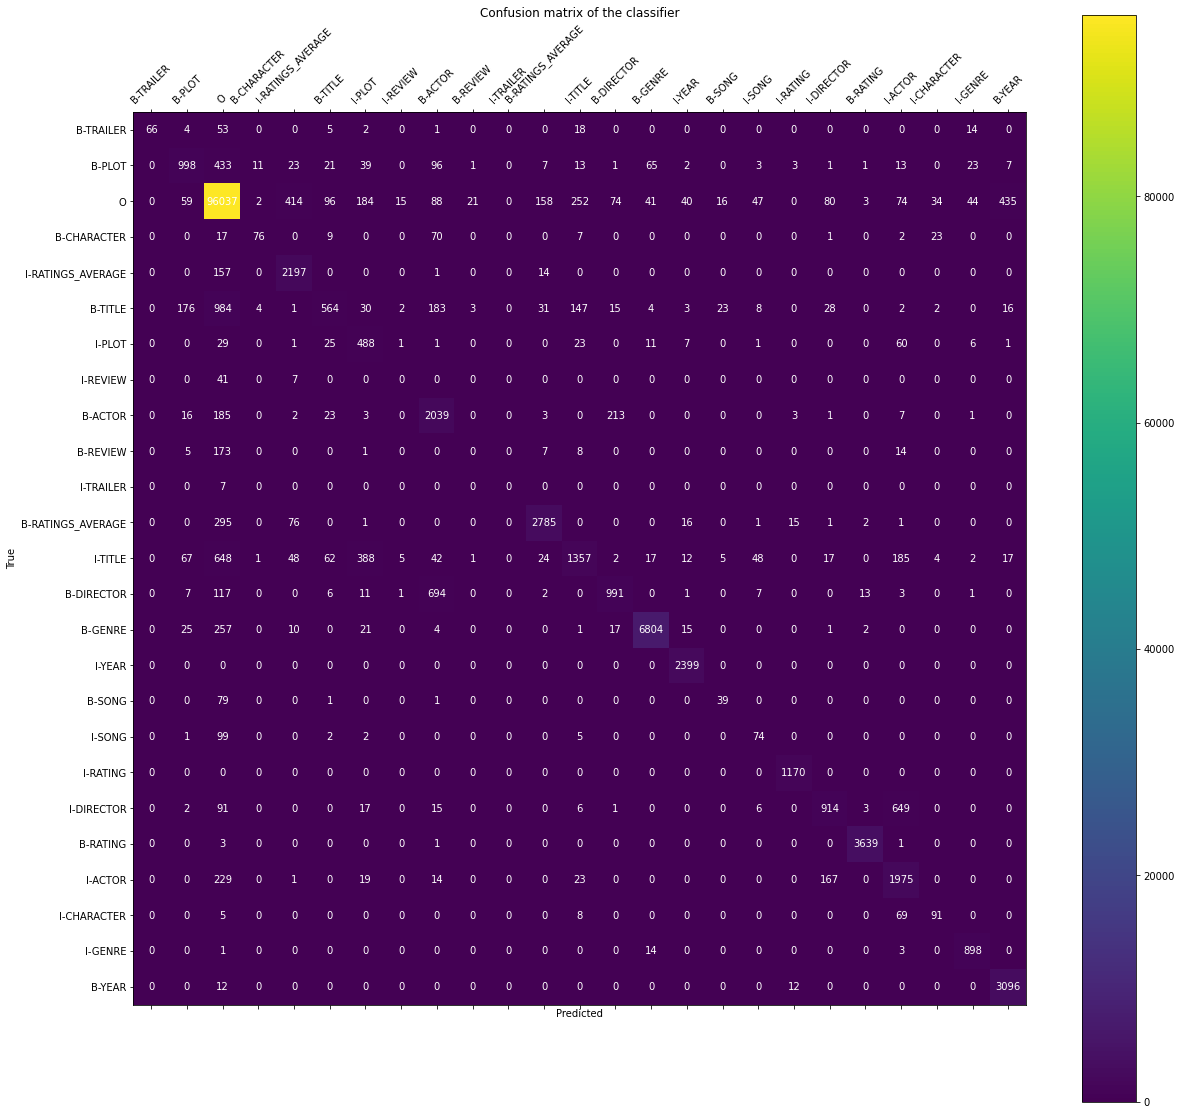

In [13]:
confusion_matrix_heatmap(y_test, preds)

In [14]:
print(classification_report(y_test, preds))

c:\users\rohit\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

          B-ACTOR       0.63      0.82      0.71      2496
      B-CHARACTER       0.81      0.37      0.51       205
       B-DIRECTOR       0.75      0.53      0.63      1854
          B-GENRE       0.98      0.95      0.96      7157
           B-PLOT       0.73      0.57      0.64      1761
         B-RATING       0.99      1.00      1.00      3644
B-RATINGS_AVERAGE       0.92      0.87      0.89      3193
         B-REVIEW       0.00      0.00      0.00       208
           B-SONG       0.47      0.33      0.38       120
          B-TITLE       0.69      0.25      0.37      2226
        B-TRAILER       1.00      0.40      0.58       163
           B-YEAR       0.87      0.99      0.93      3120
          I-ACTOR       0.65      0.81      0.72      2428
      I-CHARACTER       0.59      0.53      0.56       173
       I-DIRECTOR       0.75      0.54      0.63      1704
          I-GENRE       0.91      0.98      0.94       

Here i have printed the classification report and the macro average of the development data for precision is 0.68 , for recall is 0.62 and for f1-score is 0.63

For this classification we have used pos tags so now comparing this classification report with the classification report from the Question 2 where we have not used the pos tags.

There are slight increases in the macro averages in classification with pos tags. The total increase in precision is 0.03 , recall is the same and f1 score increases by 0.01 

By comparing individual classes in both the classification report the precisions have increased for some classes and reduced signifiantly for other classes.

For Example:
I-SONG precision has increased from 0.29 to 0.38
B-PLOT precision has increased significantly form 0.48 to 0.73
Whereas,
B-ACTOR has decreased from 0.65 precision to 0.63. 
All the other classes have minor increase in their precisions.

Same is the case for recall for classes of both the reports
For Example:
The recall of B-Director is decreased from 0.63 to 0.53
Whereas,
The recall of I-PLOT increased from 0.64 to 0.75
All other classes also have some variations 

For F1-Score:
B-Character F1 score increased from 0.44 to 0.51
B-DIRECTOR F1 score decreased from 0.69 to 0.63
Here also some variations for classes in both the reports.
These changes here are due to the pos tags.

In question 5 further adding the features the macro averages og precision recall and f score can be improved.